# Testing Frequency dependent model on Experimental data
The version of the model suffers from predicting multiple solutions on perfectly clean synthetic data.  
This data is not real and does not represent a physical material.  
This maybe what is causing the multiple solutions error. Testing on this silicon dataset will allow us to test the model on real data.


In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import FrequencyDependentModel, IndependentFrequencyModel
from Model.back_prop_utils import H_th_function, H_prime_function,round_to_sig_figs, c, torch_unwrap, newton_raphson_fitting
from Model.plotting_utils import plot_transfer, plot_comparison, plot_training_progress, plot_material_params
from Model.loss_functions import loss, complex_transfer_loss, complex_real_imag_loss, log_complex_loss, log_complex_loss_smooth, complex_real_imag_loss_smoothed

## Load experimental data

In [2]:
## Move file directory to import Extractor for signal manipulation
# Save the original sys.path
original_sys_path = sys.path.copy()

try:
    # Move two levels up to THz-TDS and add it to sys.path
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

    # Now import Extractor
    from Extraction.Extractor import Extractor

finally:
    # Restore sys.path to its original state
    sys.path = original_sys_path

In [3]:
# Define file paths within THz-TDS repo
ref_path = "../../Data_sets/simple_data/ref.pulse.csv"
sample_path = "../../Data_sets/simple_data/Si.pulse.csv"

# Load data 
ref = pd.read_csv(ref_path).to_numpy()
sample = pd.read_csv(sample_path).to_numpy()

In [4]:
print("Reference shape:", ref.shape)
print("Sample shape:", sample.shape)

Reference shape: (701, 2)
Sample shape: (701, 2)


In [5]:
extractor = Extractor(ref, sample, thickness=3*1e-3)

Reference:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -37.46477718688622
Mean squared error:  0.0671512209065479
(Should be ~< 1.)
--------------------
Sample:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -192.24418598426507
Mean squared error:  0.06413903301303736
(Should be ~< 1.)
--------------------
Transfer function:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -154.77940879737844
Mean squared error:  6.112181585650803e-05
(Should be ~< 1.)
--------------------


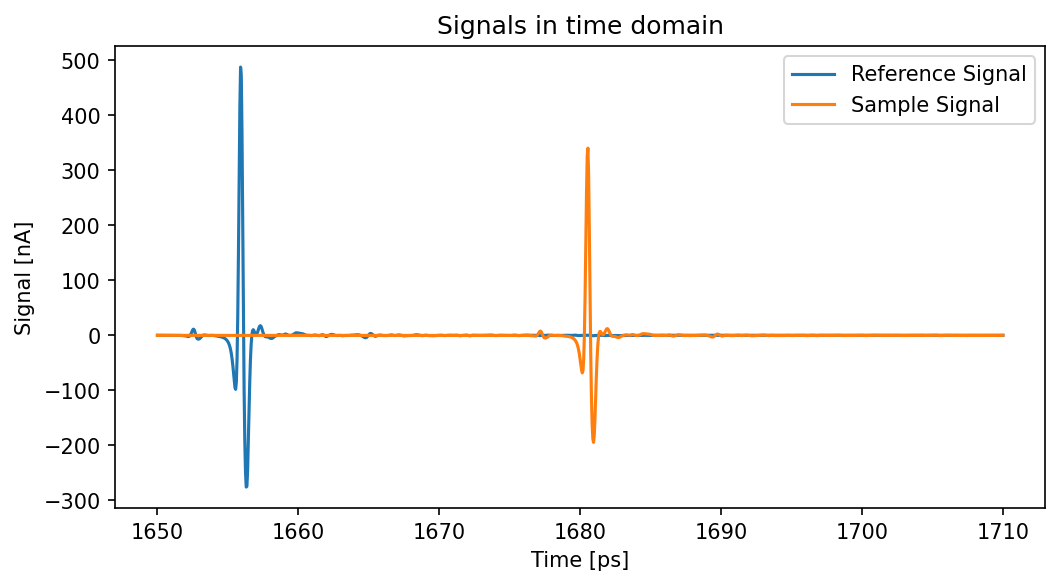

In [6]:
extractor.plot_time_domain()

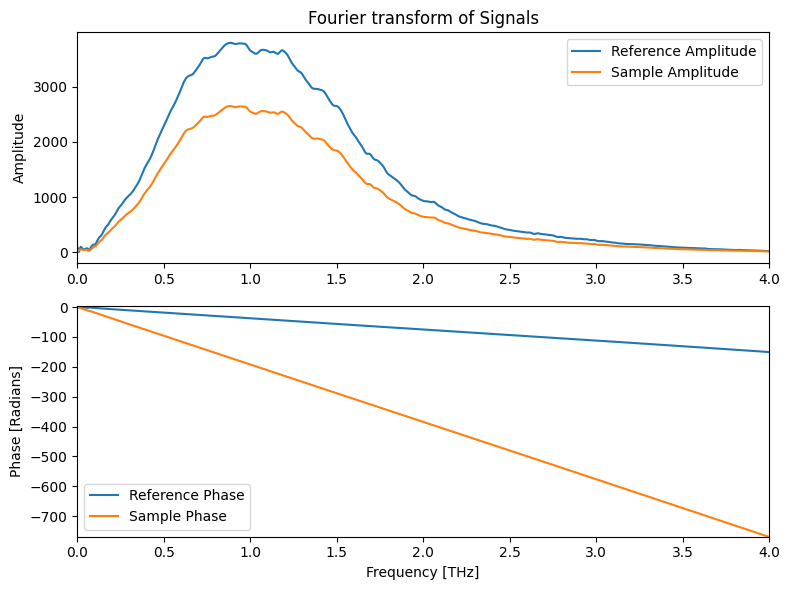

In [7]:
extractor.plot_frequency_domain(x_lims=[0,4])

In [8]:
df = extractor.get_fft_data()
df

,interpolated frequency,amplitude_signal_ref,amplitude_signal_sample,phase_signal_ref,phase_signal_sample,amplitude_transfer,phase_transfer,fast_n
0,0.000000,95.148531,15.572690,-0.429684,2.716322,0.163667,-3.137179,9.405027e+24
1,0.004880,69.694027,23.909452,-1.262713,0.623413,0.343063,-4.397059,1.533071e+01
2,0.009760,6.948951,37.244900,-1.993110,-0.880350,5.359788,-5.170426,9.425614e+00
3,0.014640,60.338845,47.704227,0.215530,-2.192593,0.790606,-2.408124,3.616151e+00
4,0.019520,98.849323,53.157152,-0.549669,-3.419308,0.537759,-2.869639,3.338151e+00
...,...,...,...,...,...,...,...,...
4091,19.963827,94.167196,53.476666,-2179.898373,-5123.353733,0.567891,-2956.021730,3.354959e+00
4092,19.968707,98.849323,53.157152,-2180.575001,-5124.510444,0.537759,-2956.501814,3.354766e+00
4093,19.973587,60.338845,47.704227,-2181.340200,-5125.737159,0.790606,-2956.963329,3.354558e+00
4094,19.978467,6.948951,37.244900,-2179.131560,-5127.049402,5.359788,-2954.201027,3.351784e+00


## Setup data for optimization

In [9]:
# Define frequency range we are interested in.
freqs_range = [0.3, 2]

freqs_THz = df['interpolated frequency']

# Find the closest available values within the range
lower_bound = freqs_THz[freqs_THz >= freqs_range[0]].min()
upper_bound = freqs_THz[freqs_THz <= freqs_range[1]].max()

# Apply the boundaries
# Ensure df['frequency'] exists and corresponds to freqs_THz
df_filtered = df[(df['interpolated frequency'] >= lower_bound) & (df['interpolated frequency'] <= upper_bound)]
freqs_THz = freqs_THz[(freqs_THz >= lower_bound) & (freqs_THz <= upper_bound)]

H_values = df_filtered['amplitude_transfer']
phi_values = df_filtered['phase_transfer'] 

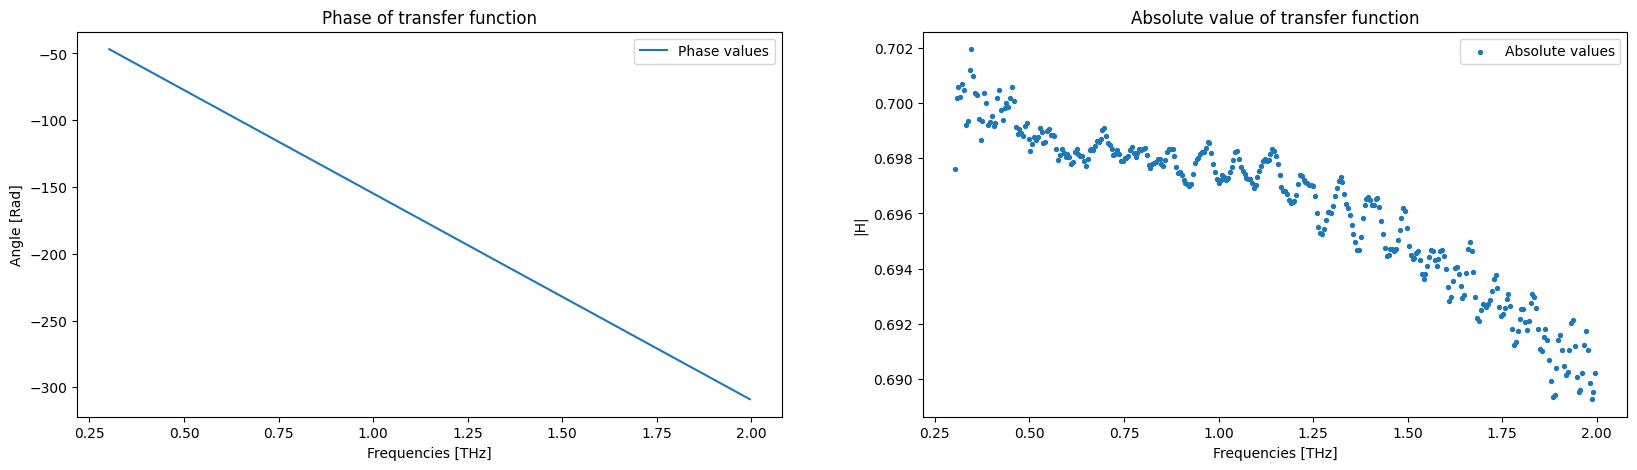

In [10]:
plot_transfer(freqs_THz, H_values, phi_values)

In [11]:
def abs_loss(H_exp, H_pred):
    abs_loss = torch.nn.functional.mse_loss(torch.abs(H_pred), torch.abs(H_exp))
    return abs_loss

def MAE(H_exp, H_pred):
    real_loss = torch.mean(torch.abs(torch.real(H_pred) - torch.real(H_exp)))
    imag_loss = torch.mean(torch.abs(torch.imag(H_pred) - torch.imag(H_exp)))

    return real_loss + imag_loss

Epoch 0: Loss = 0.9473544955253601 (Best Loss = 0.9473544955253601)
Epoch 500: Loss = 6.845254224563391e-11 (Best Loss = 4.159372152257035e-11)
Epoch 1000: Loss = 1.2098626267498247e-10 (Best Loss = 4.120529611961743e-11)
Epoch 1500: Loss = 5.3873002059390274e-08 (Best Loss = 4.120529611961743e-11)
Epoch 2000: Loss = 6.967978549710097e-08 (Best Loss = 4.120529611961743e-11)
Epoch 2500: Loss = 1.1109616480098339e-06 (Best Loss = 4.120529611961743e-11)


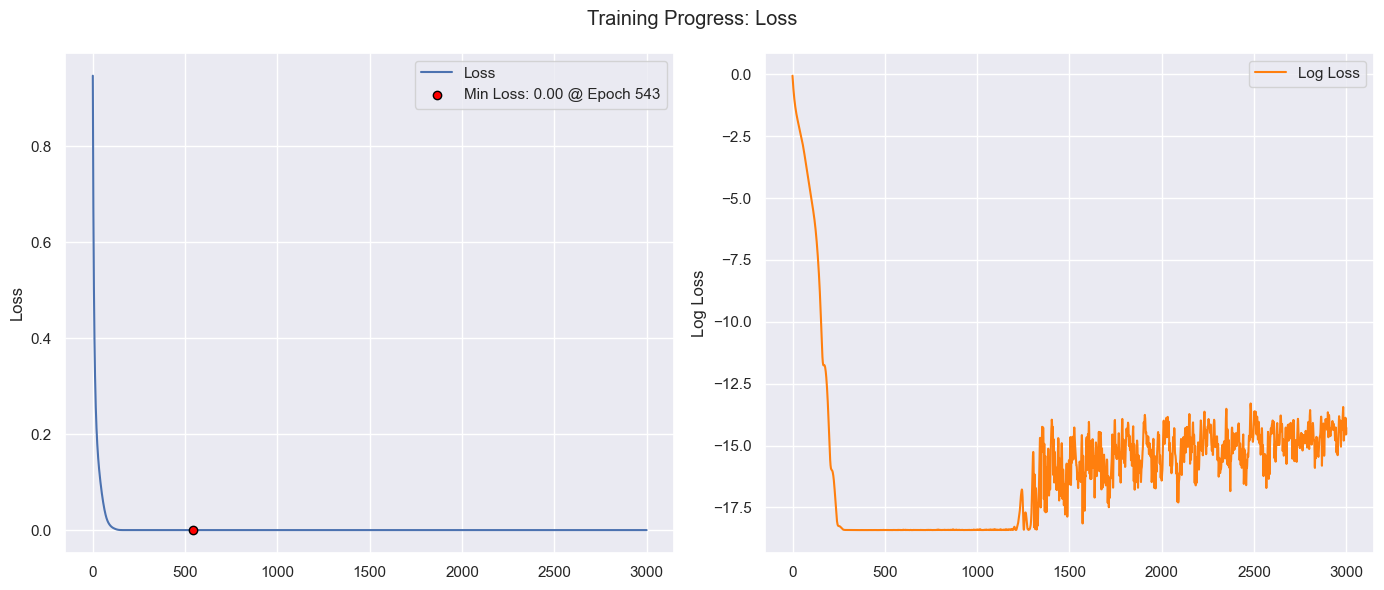

In [12]:
thickness = 3*1e-3
freqs = freqs_THz * 2 * np.pi * 1e12
freqs = torch.tensor(freqs.to_numpy(), dtype=torch.float32)

H_abs_t = torch.tensor(H_values.to_numpy(), dtype=torch.float32)
H_phi_t = torch.tensor(phi_values.to_numpy(), dtype=torch.float32)

H_exp = H_abs_t * torch.exp(1j*H_phi_t)

model = FrequencyDependentModel(freqs, thickness, 3.2, 0.0001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train_model(H_exp=H_exp, Physical_model=H_th_function, loss_fn=complex_real_imag_loss, epochs=3000, optimizer=optimizer)
plot_training_progress(model.loss_history)

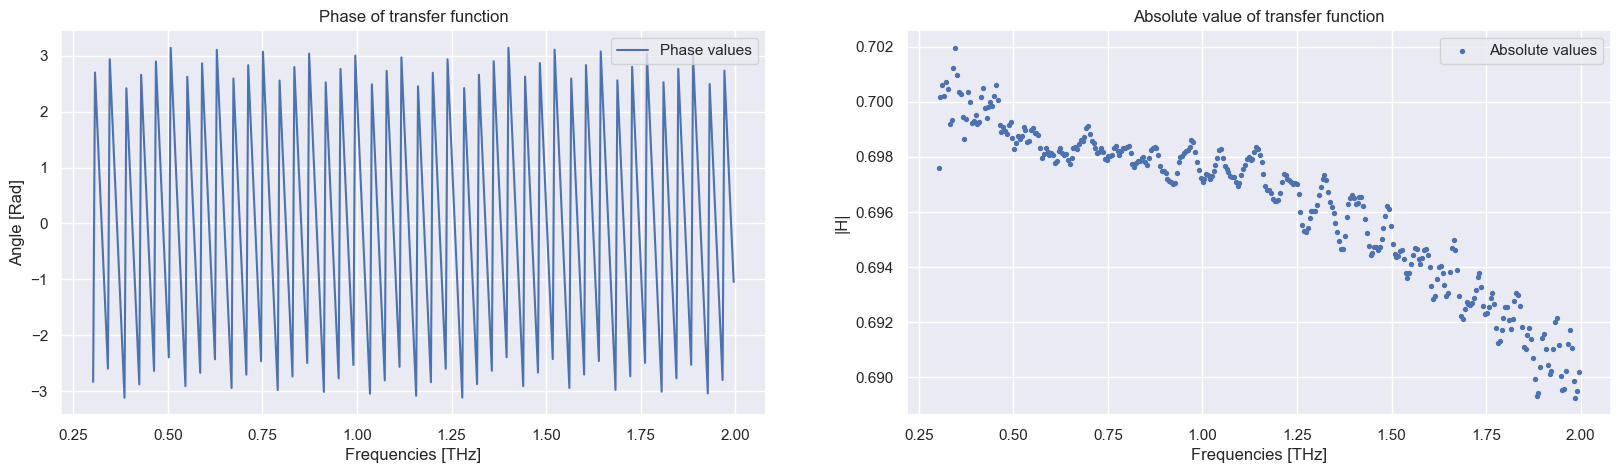

In [13]:
n_opt = model.best_n
k_opt = model.best_k

complex_opt = n_opt + 1j*k_opt
H_indep = H_th_function(n_complex=complex_opt, w=freqs, length=thickness)

plot_transfer(frequencies=freqs_THz, absolute_values=torch.abs(H_indep), phase_values=torch.angle(H_indep))

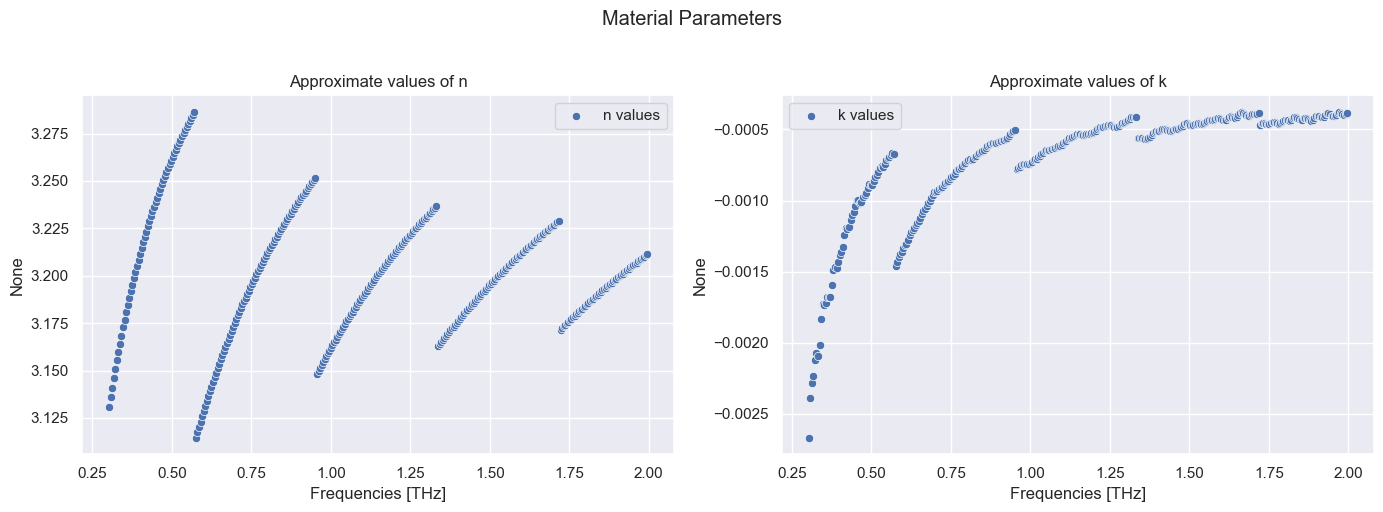

In [14]:
plot_material_params(freqs_THz, n_opt, k_opt)

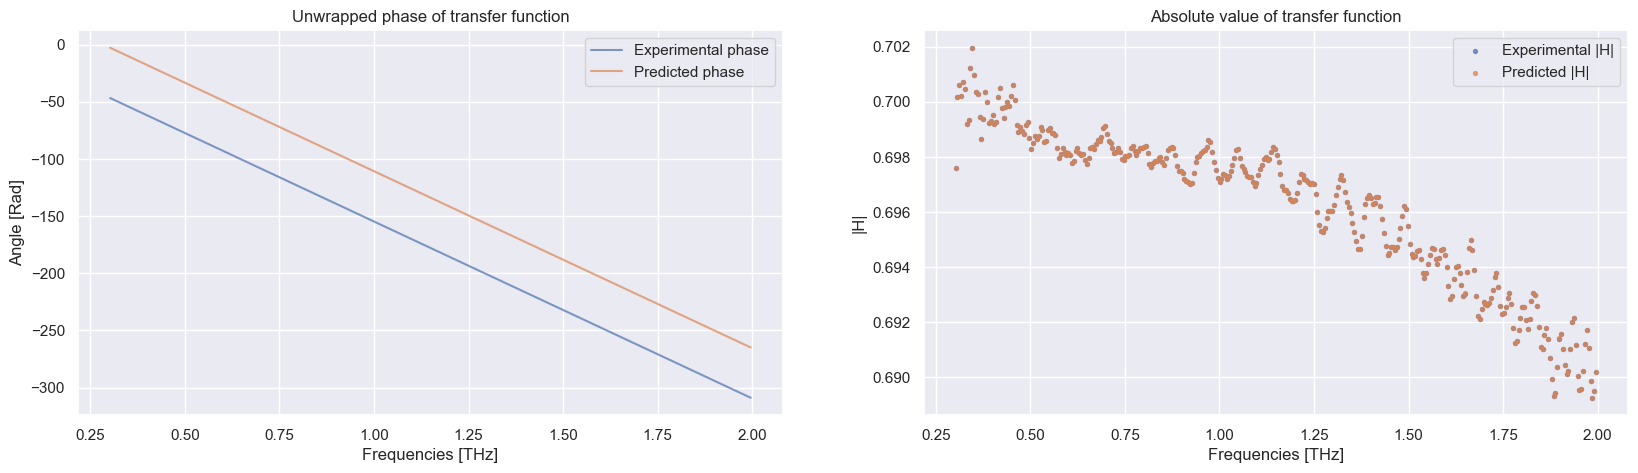

In [15]:
plot_comparison(freqs_THz, H_values, phi_values, torch.abs(H_indep), np.unwrap(torch.angle(H_indep)))